# Playground for optimization with neural networks

In [ ]:
%matplotlib inline
from functools import partial
import sys
import GPyOpt
import numpy as np
from shinyutils.matwrap import MatWrap as mw
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tensorboardX import SummaryWriter

from infopt.nnmodel import NNModel
from infopt.ihvp import IterativeIHVP, LowRankIHVP

## Helper plot function

In [ ]:
mw.configure(context="notebook")


def plot_comp_1d(
    f_true,
    f_noisy,
    model,
    X_tr,
    Y_tr=None,
    mu=0,
    sig=1,
    X_te=np.linspace(0, 1, 200)[:, np.newaxis],
):
    if Y_tr is None:
        Y_tr = f_noisy.f(X_tr)
        model.updateModel(X_tr, Y_tr, None, None)

    Y_te = f_true.f(X_te)
    Yhat_te, s_te = model.predict(X_te)
    if sig > 0:
        Yhat_te = sig * Yhat_te
    Yhat_te = Yhat_te + mu

    fig = mw.plt().figure()
    ax = fig.add_subplot(111)
    ax.plot(X_te, Y_te, label="$f$", color="r")
    ax.scatter(
        X_tr, Y_tr, marker="x", color="r", label=f"Training data ($n={len(X_tr)}$)"
    )
    ax.plot(X_te, Yhat_te, label="$\hat{f}$", color="b", ls="--")
    X_te, Yhat_te, s_te = X_te[:, 0], Yhat_te[:, 0], s_te[:, 0]
    ax.fill_between(X_te, Yhat_te - s_te, Yhat_te + s_te, color="b", alpha=0.25)
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    ax.legend()
    mw.sns().despine(fig=fig, ax=ax, trim=True)


## Network used to model data

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1, 3)
        self.fc2 = nn.Linear(3, 3)
        self.fc3 = nn.Linear(3, 1)

    def forward(self, x):
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        return self.fc3(x)


## Objective function

In [ ]:
f_true = GPyOpt.objective_examples.experiments1d.forrester(sd=0)
f_noisy = GPyOpt.objective_examples.experiments1d.forrester(sd=1)
bounds = [{"name": "var_1", "type": "continuous", "domain": (0, 1)}]
f_min = f_true.fmin


## Offline (batch) learning

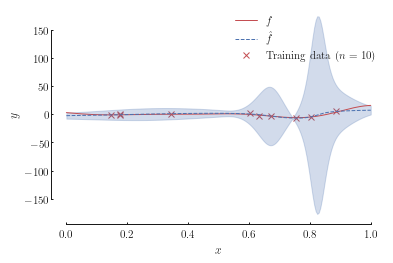

In [ ]:
tb_writer = SummaryWriter("logs/nnoffline_play")
net = Net()
ihvp = LowRankIHVP(
    net.parameters(),
    rank=5,
    batch_size=np.inf,
    optim_cls=optim.Adam,
    optim_kwargs={"lr": 0.05},
    iters_per_point=20,
    tb_writer=tb_writer,
)
# ihvp = IterativeIHVP(list(net.parameters()), iters=1000, reg=0.01, scale=50)
net_optim = optim.Adam(net.parameters(), lr=0.05)
nn_model = NNModel(
    net,
    ihvp,
    net_optim,
    update_batch_size=np.inf,
    update_iters_per_point=20,
    tb_writer=tb_writer,
)

X_tr = np.random.rand(10, 1)
plot_comp_1d(f_true, f_noisy, nn_model, X_tr)


## Online optimization

Models printout after each iteration is only available for GP and GP_MCMC models
num acquisition: 1, time elapsed: 1.49s
num acquisition: 2, time elapsed: 2.65s
num acquisition: 3, time elapsed: 4.00s
num acquisition: 4, time elapsed: 5.78s
num acquisition: 5, time elapsed: 7.39s
num acquisition: 6, time elapsed: 9.33s
num acquisition: 7, time elapsed: 11.35s
num acquisition: 8, time elapsed: 13.46s
num acquisition: 9, time elapsed: 15.61s
num acquisition: 10, time elapsed: 17.56s
num acquisition: 11, time elapsed: 19.50s
num acquisition: 12, time elapsed: 22.45s
num acquisition: 13, time elapsed: 25.44s
num acquisition: 14, time elapsed: 28.47s
num acquisition: 15, time elapsed: 32.05s
num acquisition: 16, time elapsed: 35.04s
num acquisition: 17, time elapsed: 38.51s
num acquisition: 18, time elapsed: 41.60s
num acquisition: 19, time elapsed: 44.52s
num acquisition: 20, time elapsed: 47.55s


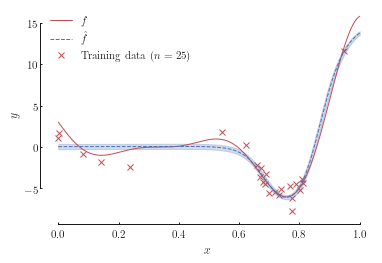

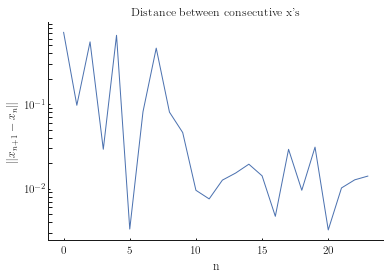

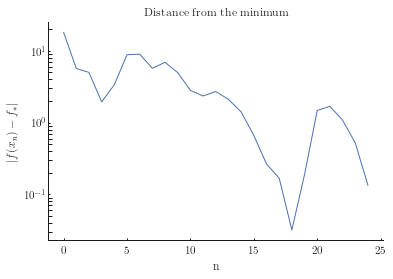

In [ ]:
tb_writer = SummaryWriter("logs/nnonline_play")
net = Net()
ihvp = LowRankIHVP(
    net.parameters(),
    rank=5,
    optim_cls=optim.Adam,
    optim_kwargs={"lr": 0.05},
    batch_size=np.inf,
    iters_per_point=10,
    tb_writer=tb_writer,
)
# ihvp = IterativeIHVP(list(net.parameters()), iters=1000, reg=0.01, scale=100)
net_optim = optim.Adam(net.parameters(), lr=0.05)
nn_model = NNModel(
    net,
    ihvp,
    net_optim,
    update_batch_size=np.inf,
    update_iters_per_point=10,
    tb_writer=tb_writer,
)

objective = GPyOpt.core.task.SingleObjective(f_noisy.f)
space = GPyOpt.Design_space(space=bounds)
acq_optimizer = GPyOpt.optimization.AcquisitionOptimizer(space)
initial_design = GPyOpt.experiment_design.initial_design("random", space, 5)
acq = GPyOpt.acquisitions.AcquisitionLCB(
    nn_model, space, acq_optimizer, exploration_weight=2
)
feval = GPyOpt.core.evaluators.Sequential(acq)
nn_bo = GPyOpt.methods.ModularBayesianOptimization(
    nn_model, space, objective, acq, feval, initial_design, normalize_Y=True
)

nn_bo.run_optimization(max_iter=20, verbosity=True, eps=-1)
mu, sig = float(nn_bo.Y.mean()), float(nn_bo.Y.std())
plot_comp_1d(f_true, f_noisy, nn_model, nn_bo.X, nn_bo.Y, mu, sig)

fig = mw.plt().figure()
ax = fig.add_subplot(111)
diffs = np.linalg.norm(nn_bo.X[1:] - nn_bo.X[:-1], axis=1)
ax.semilogy(diffs)
ax.set_ylabel("$\|x_{n+1} - x_n\|$")
ax.set_xlabel("n")
_ = ax.set_title("Distance between consecutive x's")

fig = mw.plt().figure()
ax = fig.add_subplot(111)
diffs = np.abs(f_true.f(nn_bo.X)[:, 0] - f_min)
ax.semilogy(diffs)
ax.set_ylabel("$|f(x_n) - f_*|$")
ax.set_xlabel("n")
_ = ax.set_title("Distance from the minimum")
